Mounted at /content/drive
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 258, 194, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 258, 194, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 258, 194, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 258, 194, 64)         1792      ['input_2[0][0]']             
                                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 50s 16s/step
(258, 194, 3)


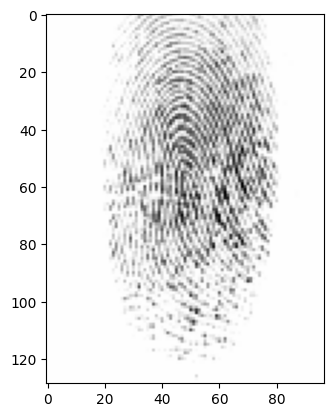

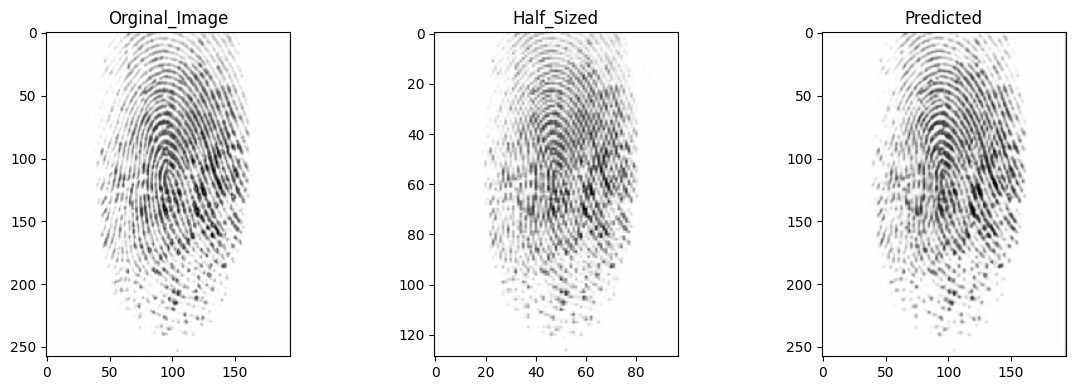

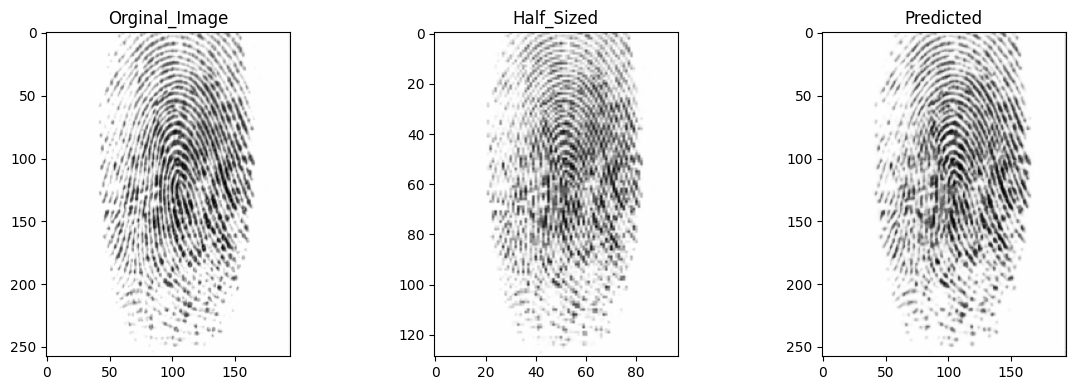

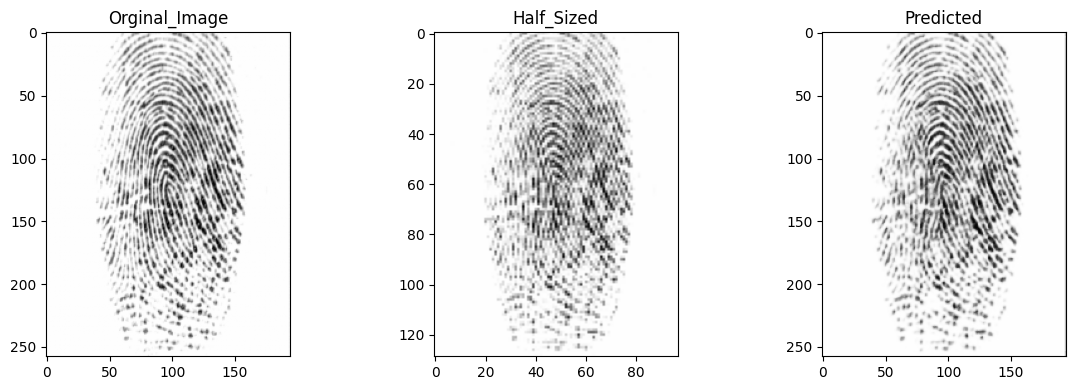

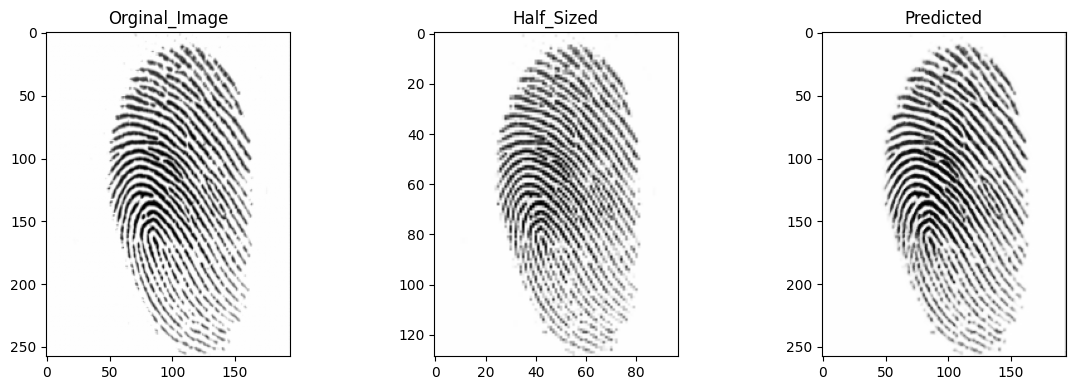

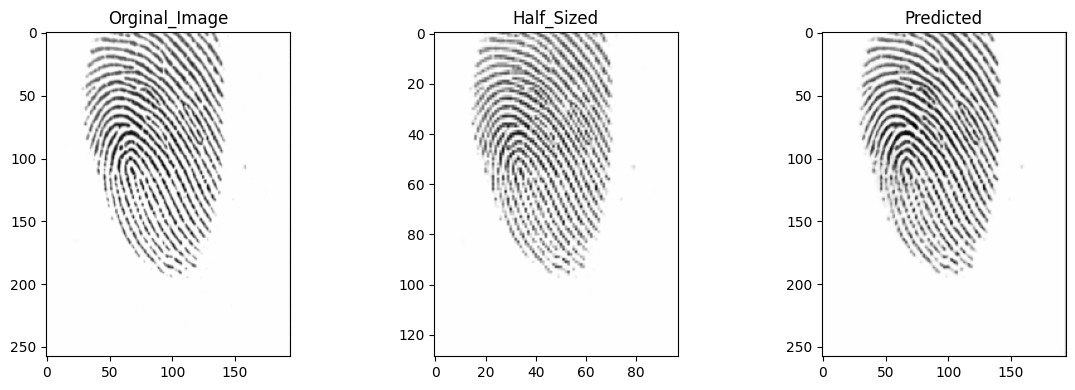

KeyboardInterrupt: ignored

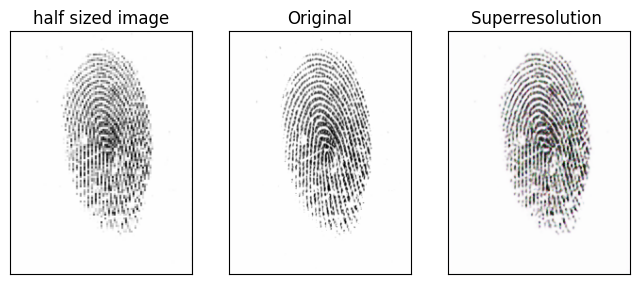

In [1]:
# -*- coding: utf-8 -*-
"""super_resolution_fingerprint (final).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1zYxFmkm02YXACxCVUFKdhFvCoOic-uti
"""



from google.colab import drive
drive.mount('/content/drive')

# -*- coding: utf-8 -*-
"""
Created on Tue Aug  8 16:27:18 2023

@author: HP
"""

"""
for image processing we will not usde dense layer because for dense layer we have to convert he vector to 1d
by this most of he essential features will be lost

"""

from matplotlib.pyplot import imshow
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import ndimage
import os
from PIL import Image

from tensorflow.keras.utils import img_to_array#to convert the image to array
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.models import Sequential,Model

np.random.seed(42)

SIZE1,SIZE2=258,194
SIZE1,SIZE2=258,194
SIZE3_1,SIZE3_2=129,97

from keras.layers import concatenate, Flatten, Dense

# Define the input layers for each of the three models
input1 = Input(shape=(SIZE1, SIZE2, 3))
input2 = Input(shape=(SIZE1, SIZE2, 3))
input3 = Input(shape=(SIZE3_1, SIZE3_2, 3))

#for 1st enlarged image


x=Conv2D(64,(3,3),activation='relu',padding='same')(input1)
x1=Conv2D(128,(3,3),activation='relu',padding='same')(x)
#x=Conv2D(256,(3,3),activation='relu',padding='same')(x)
x=MaxPooling2D((2,2),padding='same')(x1)


#for 2nd enlarged image


y=Conv2D(64,(3,3),activation='relu',padding='same')(input2)
y1=Conv2D(128,(3,3),activation='relu',padding='same')(y)
#y=Conv2D(256,(3,3),activation='relu',padding='same')(y)
y=MaxPooling2D((2,2),padding='same')(y1)

parallel_input = concatenate([x1,y1],axis=3)



#for the orginal image

z=Conv2D(64,(3,3),activation='relu',padding='same')(input3)
z=Conv2D(128,(3,3),activation='relu',padding='same')(z)
#z=Conv2D(256,(3,3),activation='relu',padding='same')(z)




#concatinate
from keras.layers import Concatenate, Flatten, Dense,Add

# Assuming the output shapes are compatible for concatenation
merged = concatenate([x,y,z],axis=3)

#model=Model([input1,input2,input3],merged)
#model.summary()
#tf.keras.utils.plot_model(model,show_shapes=True)


xx=UpSampling2D((2,2))(merged)
pxx = Concatenate(axis=-1)([parallel_input, xx])


xx=Conv2DTranspose(3,(3,3),activation='sigmoid',padding='same')(pxx)#3 for RGB
model=Model([input1,input2,input3],xx)
model.summary()


tf.keras.utils.plot_model(model,show_shapes=True)

def reduceSize(im):



    width,height = im.shape[:2]

    resized_image = cv2.resize(image, (height // 2, width // 2))

            #print(f'Resized {filename}')

    return resized_image

def bicubic(im):

    scaling_factor = 2

    enlarged_image = ndimage.zoom(im, (scaling_factor, scaling_factor,1), order=3)
    return enlarged_image

def spline(im):

    low_res_image = im

    scaling_factor = 2

    high_res_shape = (low_res_image.shape[0] * scaling_factor, low_res_image.shape[1] * scaling_factor)

    high_res_image = ndimage.zoom(im, (scaling_factor, scaling_factor, 1), order=3)

    return high_res_image

def lanczos(im):

    from scipy.ndimage import zoom
    zoom_factor = 2

    # Perform Lanczos interpolation for each channel
    interpolated_channels = [zoom(im[:, :, i], zoom_factor, order=3) for i in range(im.shape[2])]

    # Stack the interpolated channels back together
    interpolated_image = np.stack(interpolated_channels, axis=-1)

    return interpolated_image


input_directory = '/content/drive/MyDrive/SuperResolution/DB1'
all_images_list1 = []
all_images_list2=[]
all_images_list3=[]
orginal_image=[] #y
for filename in os.listdir(input_directory):
        #print(filename)
        path=os.path.join(input_directory, filename)
        image = cv2.imread(path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        img = cv2.resize(image, (194,258))
        img=img.astype('int')/255.
        print(img.shape)
        orginal_image.append(img)
        resized_image=img
        resized_image=reduceSize(img)
        bicubic_image=bicubic(resized_image)
        print("Bicubic",bicubic_image.shape)
        #lanczos_image=lanczos(resized_image)
        #print("Lanczos",lanczos_image.shape)
        spline_image=spline(resized_image)
        print("Spline",spline_image.shape)
        all_images_list1.append(bicubic_image)
        #all_images_list1.append(lanczos_image)
        all_images_list2.append(spline_image)
        all_images_list3.append(resized_image)

all_images_list1=np.array(all_images_list1)
all_images_list2=np.array(all_images_list2)
all_images_list3=np.array(all_images_list3)
orginal_image=np.array(orginal_image)
print(all_images_list1.shape)
print(all_images_list2.shape)
print(all_images_list3.shape)
print(orginal_image.shape)

x=model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

model.fit([all_images_list1,all_images_list2,all_images_list3],orginal_image,batch_size=2,epochs=30,shuffle=True)

model_path = '/content/drive/MyDrive/SuperResolution/my_model.h5'
model.save(model_path)

y_pred=model.predict([all_images_list1,all_images_list2,all_images_list3])
print(y_pred[0].shape)
imshow((y_pred[5]*255).astype(np.uint8))
imshow((orginal_image[5]*255).astype(np.uint8))

imshow((orginal_image[5]*255).astype(np.uint8))

imshow((y_pred[0]*255).astype(np.uint8))

imshow((all_images_list3[0]).astype(np.uint8))

from pandas.io.formats.printing import PrettyDict
import matplotlib.pyplot as plt
import numpy as np
for i in range (0,5):
  orginal = orginal_image[i]
  halfsized = all_images_list3[i]
  pred = cv2.cvtColor(y_pred[i], cv2.COLOR_BGR2GRAY)

  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  axs[0].imshow(orginal, cmap='gray')
  axs[0].set_title('Orginal_Image')

  axs[1].imshow(halfsized, cmap='gray')
  axs[1].set_title('Half_Sized')

  axs[2].imshow(pred, cmap='gray')
  axs[2].set_title('Predicted')

  plt.tight_layout()

  plt.show()

all_images_list3_1 =all_images_list3
orginal_image_1 = orginal_image*255
y_pred_1 = y_pred*255


fig, ax = plt.subplots(1, 3, figsize=(8, 8))

for i, (p_img, t_img, r_img) in enumerate(zip(all_images_list3_1, orginal_image_1, y_pred_1)):

    #p_img = cv2.resize(p_img, (img_spec_x, img_spec_y))
    ax[0].imshow(p_img.astype(np.uint8), cmap="gray")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("half sized image")

    #t_img = cv2.resize(t_img, (img_spec_x, img_spec_y))
    ax[1].imshow(t_img.astype(np.uint8), cmap="gray")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Original")

    #r_img = cv2.resize(r_img, (img_spec_x, img_spec_y))
    ax[2].imshow(r_img.astype(np.uint8), cmap="gray")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Superresolution ")





In [2]:
# Calculate PSNR

import cv2
import numpy as np

# Load original and processed images
original_image = cv2.imread('/content/drive/MyDrive/SuperResolution/orginal.png')
processed_image = cv2.imread('/content/drive/MyDrive/SuperResolution/processed.png')

mse = np.mean((original_image - processed_image) ** 2)


MAX = 255
psnr = 10 * np.log10((MAX ** 2) / mse)

print(f'PSNR: {psnr} dB')

#SSIM
from skimage import io, color
from skimage.metrics import structural_similarity as ssim


original_image = io.imread('/content/drive/MyDrive/SuperResolution/orginal.png')
processed_image = io.imread('/content/drive/MyDrive/SuperResolution/processed.png')

if original_image.shape[-1] == 4:
    original_image = original_image[:, :, :3]

if processed_image.shape[-1] == 4:
    processed_image = processed_image[:, :, :3]

original_image_gray = color.rgb2gray(original_image)
processed_image_gray = color.rgb2gray(processed_image)

# Calculate SSIM
ssim_score = ssim(original_image_gray, processed_image_gray)

print(f'SSIM Score: {ssim_score}')

# Calculate MSE
import numpy as np
from sklearn.metrics import mean_squared_error

y_flat = orginal_image.flatten()
ypred_flat = y_pred.flatten()

mse = mean_squared_error(y_flat, ypred_flat)

print(f'Mean Squared Error (MSE): {mse}')

import numpy as np

individual_ratings = [4.2, 3.8, 4.5, 3.6, 4.0]

mos = np.mean(individual_ratings)

print(f"Mean Opinion Score (MOS): {mos}")

def predict(image):
  unseen_image1=[]
  unseen_image2=[]
  unseen_image3=[]

  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  img = cv2.resize(image, (194,258))
  img=img.astype('int')/255.
  print(img.shape)
  resized_image=reduceSize(img)
  bicubic_image=bicubic(resized_image)
  print("Bicubic",bicubic_image.shape)
  spline_image=spline(resized_image)
  print("Spline",spline_image.shape)
  unseen_image1.append(bicubic_image)
  unseen_image2.append(spline_image)
  unseen_image3.append(resized_image)

  unseen_image1=np.array(unseen_image1)
  unseen_image2=np.array(unseen_image2)
  unseen_image3=np.array(unseen_image3)
  print(unseen_image1.shape)
  print(unseen_image2.shape)
  print(unseen_image3.shape)
  y_pred_unseen=model.predict([unseen_image1,unseen_image2,unseen_image3])
  return y_pred_unseen

path='/content/drive/MyDrive/SuperResolution/DB4_B/105_1.tif'
image = cv2.imread(path)
#plt.imshow(image)
res=predict(image)

grey = cv2.cvtColor(res[0], cv2.COLOR_BGR2GRAY)
plt.imshow(grey,cmap='gray')


PSNR: 30.019335915224268 dB
SSIM Score: 0.8243078390186491
Mean Squared Error (MSE): 0.006994962533709159
Mean Opinion Score (MOS): 4.0200000000000005


error: ignored